In [2]:
from datasets import load_dataset
import pandas as pd
import huggingface_hub
import matplotlib.pyplot as plt
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.scorer import Scorer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from torch.optim import AdamW
import pickle
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


c:\Users\Mena Lerf\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def process_text(text):
    ''' Process the text: lowercasing, lemmatization, stopwords removal, 
        and punctuation removal
        Input: text: the text to be processed'''
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('  ', ' ')

    # Word tokenization 
    tokens = word_tokenize(text)

    # Normalization (lowercasing and lemmatization)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Token filtering (stopwords removal)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalpha()]

    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text

In [4]:
def plot_classes_distribution(labels, num_samples_per_class):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.barh(labels, num_samples_per_class)
    plt.xlabel("Number of samples")
    plt.ylabel("Class")
    plt.title("Distribution of the classes")
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

In [5]:
# Load the dataset
dataset = load_dataset("argilla/medical-domain")

as a recap from exericse one, let's have a look again at the classes

In [6]:
# Calculate basic statistics
# Number of samples, number of classes, number of samples per class
# Number of samples
num_samples = len(dataset['train'])
print("Number of samples: ", num_samples)

# Number of classes
labels = []
for sample in dataset['train']['prediction']:
    label = sample[0]['label']
    if label not in labels:
        labels.append(label)

num_classes = len(labels)
print("Number of classes: ", num_classes)

Number of samples:  4966
Number of classes:  40


In [7]:
# Number of samples per class
num_samples_per_class = []
for label in labels:
    num_samples_per_class.append(len(dataset['train'].filter(lambda example: example['prediction'][0]['label'] == label)))

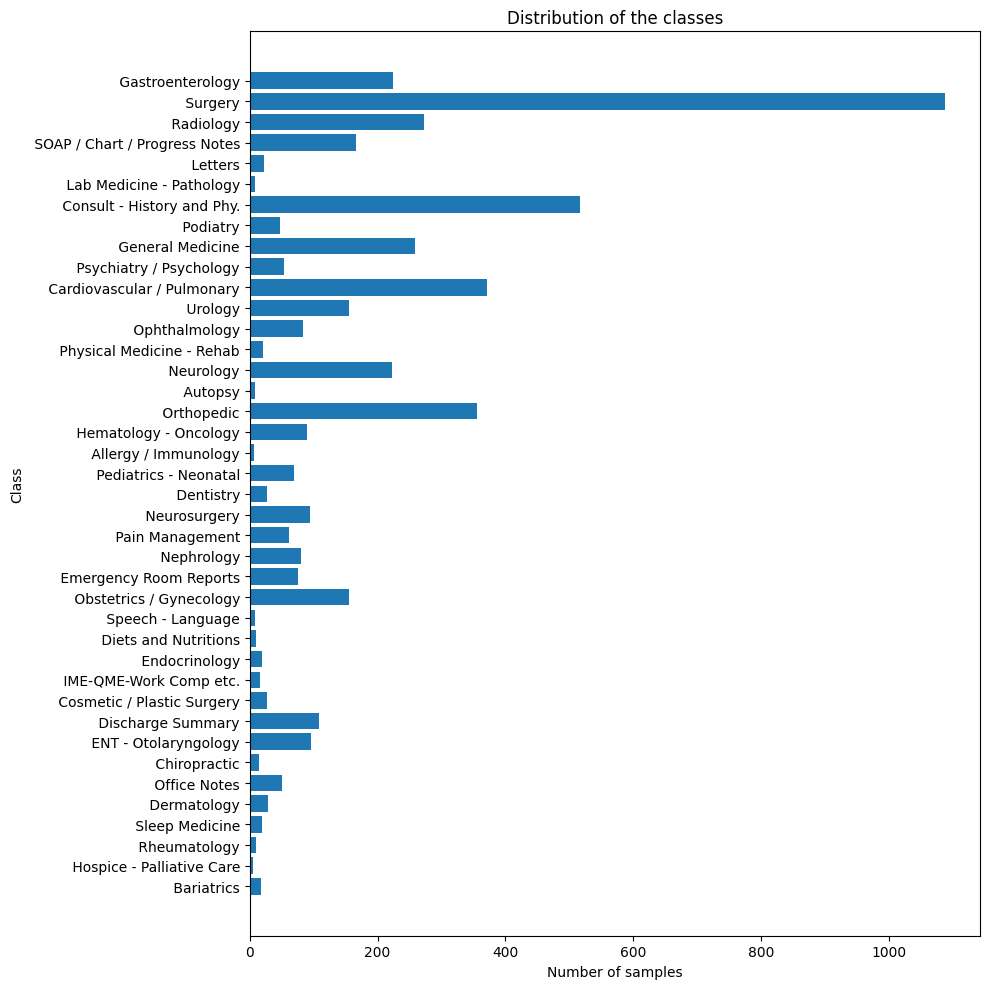

In [8]:
# plot the distribution of the classes
plot_classes_distribution(labels, num_samples_per_class)

Next we are going to set the environment that we created in Task 1 for the preprocessing of the text using the pipeline provided in our Task 1 notebook. 

In [9]:
# preprocess the data
dataset_p = pd.DataFrame(columns=['tokens', 'label'])
for i in range(len(dataset['train'])):
    text = dataset['train'][i]['text']
    label = dataset['train'][i]['prediction'][0]['label']
    text_p = process_text(text)
    dataset_p.loc[i] = [text_p, label]

In [10]:
dataset_p.head()

,tokens,label
0,preoperative diagnosis iron deficiency postope...,Gastroenterology
1,clinical indication normal stress procedure pe...,Surgery
2,finding scan performed reformatted image obtai...,Radiology
3,preoperative diagnosis blood loss postoperativ...,Surgery
4,reason visit elevated psa nocturia occasional ...,SOAP / Chart / Progress Notes


In [11]:
#how many labels are there
print(len(dataset_p['label'].unique()))
dataset_p['label'].value_counts().sort_index()

40


label
 Allergy / Immunology                7
 Autopsy                             8
 Bariatrics                         18
 Cardiovascular / Pulmonary        371
 Chiropractic                       14
 Consult - History and Phy.        516
 Cosmetic / Plastic Surgery         27
 Dentistry                          27
 Dermatology                        29
 Diets and Nutritions               10
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Emergency Room Reports             75
 Endocrinology                      19
 Gastroenterology                  224
 General Medicine                  259
 Hematology - Oncology              90
 Hospice - Palliative Care           6
 IME-QME-Work Comp etc.             16
 Lab Medicine - Pathology            8
 Letters                            23
 Nephrology                         81
 Neurology                         223
 Neurosurgery                       94
 Obstetrics / Gynecology           155
 Office Notes      

In [12]:
#convert labels to numbers
label2idx = {}
idx2label = {}
for i, label in enumerate(dataset_p['label'].unique()):
    label2idx[label] = i
    idx2label[i] = label

dataset_p['label'] = dataset_p['label'].map(label2idx)
dataset_p.head()


,tokens,label
0,preoperative diagnosis iron deficiency postope...,0
1,clinical indication normal stress procedure pe...,1
2,finding scan performed reformatted image obtai...,2
3,preoperative diagnosis blood loss postoperativ...,1
4,reason visit elevated psa nocturia occasional ...,3


In [13]:
#wnat to use clinicalBERT for classification -> use its tokenizer
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

In [14]:
# get max length of the tokens

idx = dataset_p["tokens"].apply(len).idxmax()

# Get that row
len(dataset_p.iloc[idx]["tokens"])

12039

In [15]:
# Function to return the length of tokenized text
def count_tokens(text):
    return len(tokenizer.encode(text))


# Apply the function to each row and find the maximum length
token_lengths = dataset_p["tokens"].apply(count_tokens)
max_token_length = max(token_lengths)

print("Maximum number of tokens in a single row:", max_token_length)


Maximum number of tokens in a single row: 2319


the max nb of tokens that BERT can take is 512, so this entry will be truncated to 512 tokens

In [18]:
def count_tokens(text):
    return len(tokenizer.encode(text))


token_lengths = dataset_p["tokens"].apply(count_tokens)

In [19]:
# how many tokens have lenght > 512
token_lengths[token_lengths > 512].count() / len(token_lengths)

0.3008457511075312

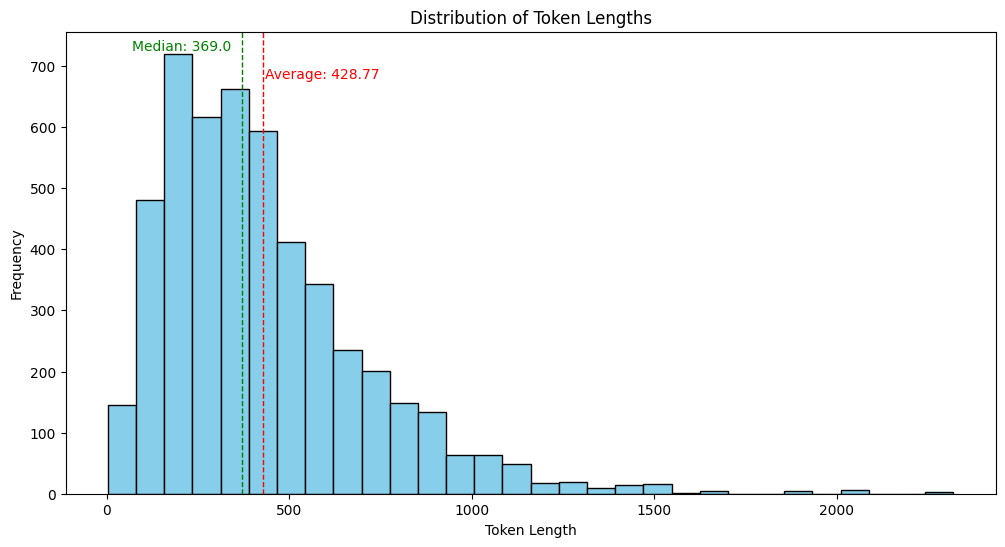

In [20]:
average_token_length = token_lengths.mean()
median_token_length = token_lengths.median()

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(average_token_length, color="red", linestyle="dashed", linewidth=1)
plt.axvline(median_token_length, color="green", linestyle="dashed", linewidth=1)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.text(
    average_token_length + 5,
    plt.ylim()[1] * 0.9,
    f"Average: {average_token_length:.2f}",
    color="red",
)
plt.text(
    median_token_length - 300,
    plt.ylim()[1] * 0.96,
    f"Median: {median_token_length}",
    color="green",
)

plt.show()

the average length is 428 tokens and the median is 369, so truncating to 512 should be fine. however, in this case 30% of the entries will be truncated

In [21]:
def tokenize(sent):
    encoded = tokenizer.encode_plus(
        text=sent,
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
    )
    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
    }

In [22]:
train_df, eval_df = train_test_split(dataset_p, test_size=0.2)

train_encodings = train_df["tokens"].apply(lambda x: tokenize(x))
eval_encodings = eval_df["tokens"].apply(lambda x: tokenize(x))

train_labels = torch.tensor(train_df["label"].values)
eval_labels = torch.tensor(eval_df["label"].values)

train_inputs = torch.cat(
    train_encodings.apply(lambda x: x["input_ids"]).tolist(), dim=0
)
train_masks = torch.cat(
    train_encodings.apply(lambda x: x["attention_mask"]).tolist(), dim=0
)

eval_inputs = torch.cat(eval_encodings.apply(lambda x: x["input_ids"]).tolist(), dim=0)
eval_masks = torch.cat(
    eval_encodings.apply(lambda x: x["attention_mask"]).tolist(), dim=0
)

In [23]:
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
eval_dataset = TensorDataset(eval_inputs, eval_masks, eval_labels)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=32)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")	

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    "medicalai/ClinicalBERT",
    num_labels=40,
)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [26]:
epochs = 4
optimizer = AdamW(model.parameters(), lr=5e-5)

from tqdm import tqdm

for epoch in range(epochs):
    print(f"Starting epoch {epoch + 1}/{epochs}...")
    model.train()

    for batch in tqdm(train_dataloader):
        batch_inputs, batch_masks, batch_labels = batch
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

Starting epoch 1/4...


  0%|          | 0/125 [00:00<?, ?it/s]

  5%|▍         | 6/125 [09:57<3:09:15, 95.42s/it] 

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch_inputs, batch_masks, batch_labels = batch
            batch_inputs = batch_inputs.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = batch_labels.to("cpu").numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average="binary"
    )

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
eval_metrics = evaluate(model, eval_dataloader)
print(
    f"Validation Results - Accuracy: {eval_metrics['accuracy']:.3f}, Precision: {eval_metrics['precision']:.3f}, Recall: {eval_metrics['recall']:.3f}, F1: {eval_metrics['f1']:.3f}"
)